In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN

from sklearn.preprocessing import StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv('C:/Users/srbol/OneDrive/Desktop/Binus/Semester 4/Deep learning/GSLC2/monthly_milk_production.csv'
                 ,index_col = "Date"
                 ,parse_dates = True)
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [3]:
df.tail()

,Production
Date,
1975-08-01,858
1975-09-01,817
1975-10-01,827
1975-11-01,797
1975-12-01,843


Data dimulai dari tahun Januari 1962 dan data produksi diambil setiap awal bulan pada tanggal satu. Dari kita periksa dibawah, berarti ada total 168 bulan yang tercatat dalam data, dan pencatatan terakhir ada pada Desember 1975. Mari kita bagi Januari 1962 - Desember 1973 sebagai data untuk training, dan dimulai dari Januari 1974 akan digunakan untuk testing dan prediction

Pembagian seperti itu lebih ideal dan baik dilakukan dibandingkan kita menggunakan memisahkkan data secara acak begitu saja, ini bertujuan agar model kita tidak pernah melihat data testingnya saat tahap training. Kemudian juga untuk bisa memprediksi dan belajar dari pola-pola sebelumnya

In [4]:
print(len(df))

168


In [5]:
train_data, test_data = df.iloc[:144], df.iloc[144:]
test_data

,Production
Date,
1974-01-01,828
1974-02-01,778
1974-03-01,889
1974-04-01,902
1974-05-01,969
1974-06-01,947
1974-07-01,908
1974-08-01,867
1974-09-01,815


<AxesSubplot:xlabel='Date'>

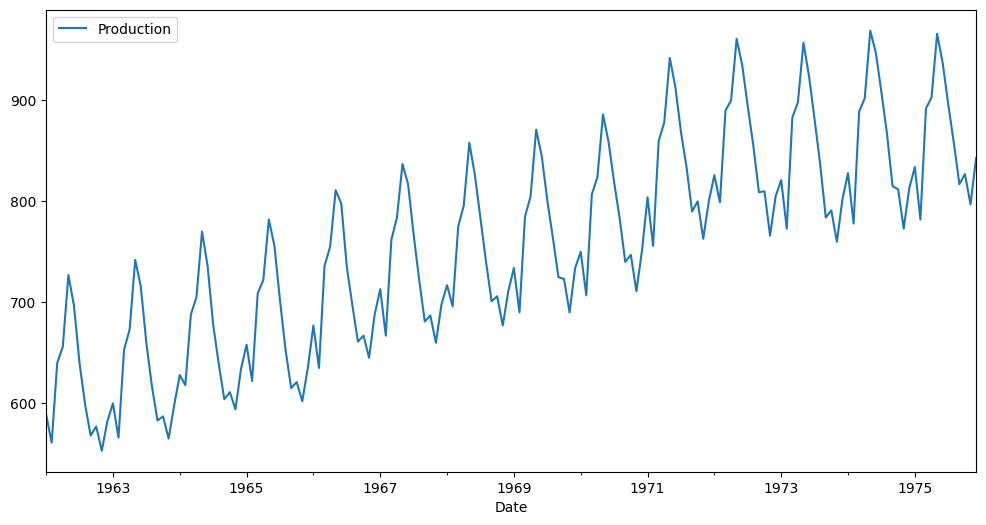

In [6]:
df.index.freq = 'MS'
df.plot(figsize = (12,6))

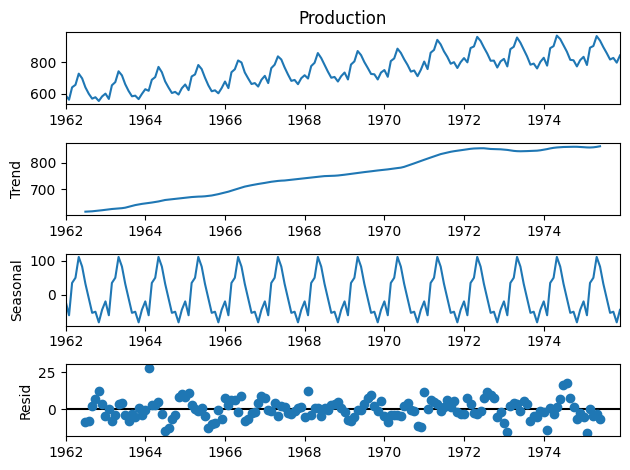

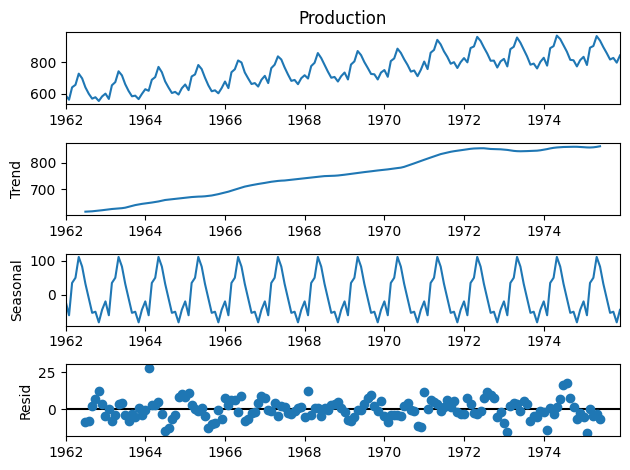

In [7]:
seasonal_decompose(df['Production']).plot()

In [8]:
scaler = MinMaxScaler()
scaler.fit(train_data)
scaleTrain = scaler.transform(train_data)
scaleTest  = scaler.transform(test_data)

generator = TimeseriesGenerator(scaleTrain, scaleTrain, length=3, batch_size=1)
#length 3 untuk prediksi setiap 3 bulan, atau dengan timestamp 3M / 1Q
#batch_size disini hanya menggunakan 1 karena saya menggunakan univariate timestamp, ubah mengikuti jumlah timestamp.
X,y = generator[0]

In [9]:
X.shape

(1, 3, 1)

In [10]:
#1Y timestamp
generator12 = TimeseriesGenerator(scaleTrain, scaleTrain, length=12, batch_size=1)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(12, 1)))
model.add(SimpleRNN(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [11]:
history = model.fit(generator12, epochs = 50)

Epoch 1/50
132/132 [==============================] - 4s 21ms/step - loss: 0.0546
Epoch 2/50
132/132 [==============================] - 3s 20ms/step - loss: 0.0208
Epoch 3/50
132/132 [==============================] - 3s 22ms/step - loss: 0.0181
Epoch 4/50
132/132 [==============================] - 3s 23ms/step - loss: 0.0289
Epoch 5/50
132/132 [==============================] - 3s 23ms/step - loss: 0.0207
Epoch 6/50
132/132 [==============================] - 3s 23ms/step - loss: 0.0128
Epoch 7/50
132/132 [==============================] - 3s 21ms/step - loss: 0.0097
Epoch 8/50
132/132 [==============================] - 3s 22ms/step - loss: 0.0079
Epoch 9/50
132/132 [==============================] - 3s 23ms/step - loss: 0.0056
Epoch 10/50
132/132 [==============================] - 3s 23ms/step - loss: 0.0038
Epoch 11/50
132/132 [==============================] - 3s 23ms/step - loss: 0.0040
Epoch 12/50
132/132 [==============================] - 3s 24ms/step - loss: 0.0051
Epoch 13/50
1

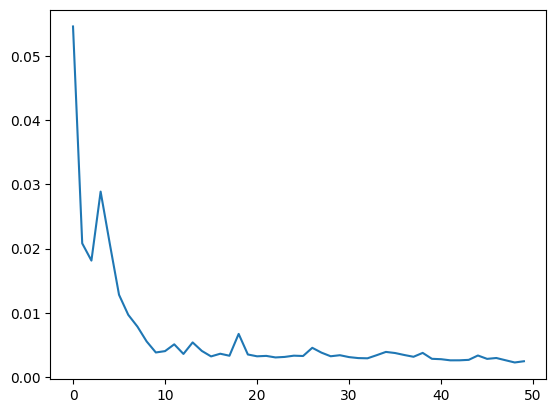

In [12]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [13]:
predictions = []

last_train_batch = scaleTrain[-12:]
last_train_batch = last_train_batch.reshape((1, 12, 1))
model.predict(last_train_batch)

first_eval_batch = scaleTrain[-12:]
currentBatch = first_eval_batch.reshape((1, 12, 1))

for i in range(len(test_data)):
    pred = model.predict(currentBatch)[0]
    predictions.append(pred) 
    currentBatch = np.append(currentBatch[:,1:,:],[[pred]],axis=1)

In [18]:
predictions

[array([0.61983216], dtype=float32),
 array([0.6244567], dtype=float32),
 array([0.7896173], dtype=float32),
 array([0.8565781], dtype=float32),
 array([0.91935194], dtype=float32),
 array([0.887625], dtype=float32),
 array([0.80990535], dtype=float32),
 array([0.6908547], dtype=float32),
 array([0.5958209], dtype=float32),
 array([0.5666626], dtype=float32),
 array([0.5433156], dtype=float32),
 array([0.57400584], dtype=float32),
 array([0.6018187], dtype=float32),
 array([0.64936936], dtype=float32),
 array([0.77347255], dtype=float32),
 array([0.8439853], dtype=float32),
 array([0.8903771], dtype=float32),
 array([0.8734325], dtype=float32),
 array([0.807449], dtype=float32),
 array([0.6925287], dtype=float32),
 array([0.6030781], dtype=float32),
 array([0.5641315], dtype=float32),
 array([0.5488202], dtype=float32),
 array([0.56105816], dtype=float32)]

In [17]:
test_data.head()

,Production,Predictions
Date,,
1974-01-01,828,805.891521
1974-02-01,778,807.778335
1974-03-01,889,875.163858
1974-04-01,902,902.483870
1974-05-01,969,928.095590


In [14]:
withoutScaler = scaler.inverse_transform(predictions)
test_data['Predictions'] = withoutScaler

C:\Users\srbol\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Dari grafik prediksi dibawah kita bisa lihat kalau apa yang diprediksi dan produksi sebenarnya masih belum akurat dan bahkan kekurangan

<AxesSubplot:xlabel='Date'>

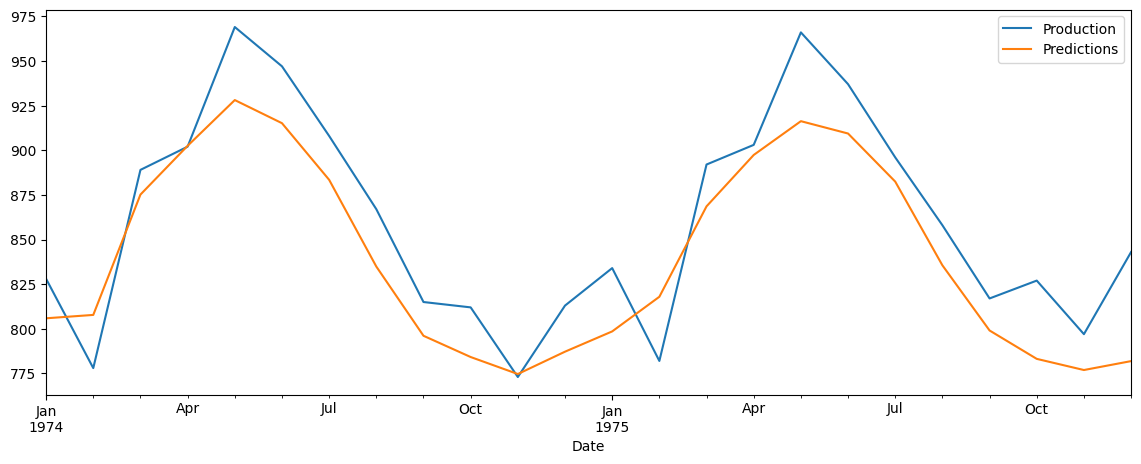

In [15]:
test_data.plot(figsize=(14,5))

In [16]:
from math import sqrt
rmse=sqrt(mean_squared_error(test_data['Production'],test_data['Predictions']))
print(rmse)

29.66622387891891
